<a href="https://colab.research.google.com/github/Sagyam/Handwritten-Optical-Character-Recognition/blob/main/Train_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import itertools    
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract the tar file

In [3]:
import pathlib
import tarfile

dataset_location = "/content/drive/MyDrive/Colab Notebooks/Minor Project/16-class-V3.tgz"

open_tarfile=tarfile.open(dataset_location)
open_tarfile.extractall()
open_tarfile.close()

data_dir = pathlib.Path('current-dataset')

In [4]:
image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =",image_count)

Total no of images = 8751


# Check some images

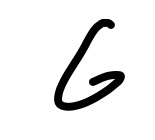

In [5]:
digits = list(data_dir.glob('6/*'))
PIL.Image.open(str(digits[0]))

# Split data into train test

In [6]:
batch_size = 32
img_height = 100
img_width = 100

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8751 files belonging to 16 classes.
Using 7001 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8751 files belonging to 16 classes.
Using 1750 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']


# Check the split dataset

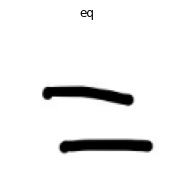

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
   

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


# Building the Model

## Custom CNN Model

In [12]:
num_classes = 16
img_channels = 3

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0

In [15]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
219/219 [==============================] - 74s 335ms/step - loss: 15.3038 - accuracy: 0.3449 - val_loss: 0.6868 - val_accuracy: 0.7949
Epoch 2/5
219/219 [==============================] - 74s 336ms/step - loss: 0.5692 - accuracy: 0.8271 - val_loss: 0.5096 - val_accuracy: 0.8674
Epoch 3/5
219/219 [==============================] - 74s 336ms/step - loss: 0.3297 - accuracy: 0.9000 - val_loss: 0.3535 - val_accuracy: 0.9074
Epoch 4/5
219/219 [==============================] - 73s 333ms/step - loss: 0.1652 - accuracy: 0.9470 - val_loss: 0.3789 - val_accuracy: 0.9126
Epoch 5/5
219/219 [==============================] - 73s 332ms/step - loss: 0.1465 - accuracy: 0.9546 - val_loss: 0.3704 - val_accuracy: 0.9189


# Visualize training results

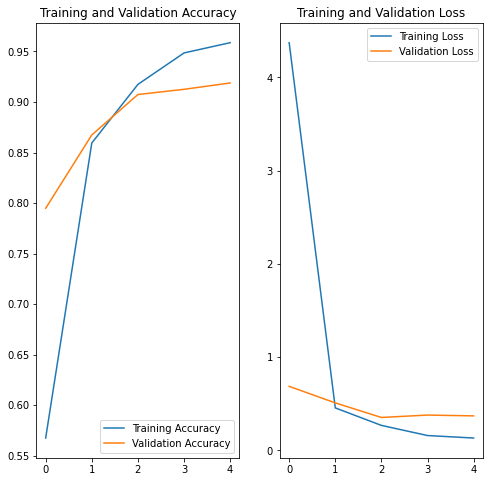

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Confusion Matrix

In [43]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

y_pred = model.predict(val_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)
figure = plot_confusion_matrix(cm, class_names)

InvalidArgumentError: ignored

In [ ]:
model_name= "CNN-" + str(num_classes) + "-cats.h5"
model.save(model_name)


# Predict on new data

In [ ]:
# test_image_path = "/content/"
# test_image = PIL.Image.open(test_image_path)

# img = keras.preprocessing.image.load_img(
#     test_image_path, target_size=(img_height, img_width)
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

# Convert model to Web suitable format

In [ ]:
!pip install tensorflowjs[wizard]

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 112kB 6.0MB/s 
     |████████████████████████████████| 256kB 6.2MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp37-none-any.whl size=32853 sha256=50229b8c8e71bcef94003205e40efbc6adc9a38d8df49e2d91a8a9359fc16192
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [ ]:
!tensorflowjs_converter --input_format=keras /content/CNN-16-cats.h5 //content/CNN-16-cats

2021-03-07 03:25:10.432506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
